# Customer Lifetime Value Prediction

This notebook contains the process for training and creating a pipeline to predict customer lifetime value and to segment customers

In [1]:
#Import the neccesary libraries
import warnings
warnings.filterwarnings('ignore')
import random

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gr
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from tabulate import tabulate

In [2]:
#Import and preprocess dataset
df = pd.read_csv("uk_dataset_full.csv")
df.columns = df.columns.str.replace(' ', '')
df.rename(columns={"Price":"UnitPrice"},inplace=True)
df.head(5)

,Unnamed:0,Invoice,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [3]:
#Remove return orders and cancelled orders
# Handling Return Orders
# Extracting rows where InvoiceNo starts with "C"
data_raw = df.copy()
cancelled_orders = data_raw[data_raw['Invoice'].astype(str).str.startswith("C")]

# Create a temporary DataFrame with the columns we want to match on, and also negate the 'Quantity' column
cancelled_orders['Quantity'] = -cancelled_orders['Quantity']

# Merge the original DataFrame with the temporary DataFrame on the columns we want to match
merged_data = pd.merge(data_raw, cancelled_orders[['CustomerID', 'StockCode', 'Quantity', 'UnitPrice']], 
                       on=['CustomerID', 'StockCode', 'Quantity', 'UnitPrice'], 
                       how='left', indicator=True)

# Filter out rows where the merge found a match, and also filter out the original return orders
data_raw = merged_data[(merged_data['_merge'] == 'left_only') & (~merged_data['Invoice'].astype(str).str.startswith("C"))]

# Drop the indicator column
data_raw = data_raw.drop(columns=['_merge'])

# Selecting relevant features and calculating total sales
features = ['CustomerID', 'Invoice', 'InvoiceDate', 'Quantity', 'UnitPrice', 'Country']
data = data_raw[features]
data['TotalSales'] = data['Quantity'].multiply(data['UnitPrice'])

# Removing transactions with missing customer IDs as they don't contribute to individual customer behavior
data = data[data['CustomerID'].notna()]
data['CustomerID'] = data['CustomerID'].astype(int).astype(str)
data.head()

,CustomerID,Invoice,InvoiceDate,Quantity,UnitPrice,Country,TotalSales
0,13085,489434,2009-12-01 07:45:00,12,6.95,United Kingdom,83.4
1,13085,489434,2009-12-01 07:45:00,12,6.75,United Kingdom,81.0
2,13085,489434,2009-12-01 07:45:00,12,6.75,United Kingdom,81.0
3,13085,489434,2009-12-01 07:45:00,48,2.10,United Kingdom,100.8
4,13085,489434,2009-12-01 07:45:00,24,1.25,United Kingdom,30.0


In [4]:
from lifetimes import GammaGammaFitter
from lifetimes import BetaGeoFitter
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.utils import summary_data_from_transaction_data

# create summary data from transaction data
summary = summary_data_from_transaction_data(data, 
                                             customer_id_col = 'CustomerID', 
                                             datetime_col = 'InvoiceDate', 
                                             monetary_value_col='TotalSales',
                                             observation_period_end = max(df["InvoiceDate"]))

summary = summary[summary["monetary_value"] > 0]

# fit the BG/NBD model
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

# fit the Gamma-Gamma submodel
ggf = GammaGammaFitter(penalizer_coef=0.0)
ggf.fit(summary['frequency'], summary['monetary_value'])


# predict customer lifetime value
summary['predicted_purchases'] = bgf.predict(30, summary['frequency'], summary['recency'], summary['T'])
summary['predicted_clv'] = ggf.customer_lifetime_value(bgf, 
                                                       summary['frequency'],
                                                       summary['recency'],
                                                       summary['T'],
                                                       summary['monetary_value'],
                                                       time=1, #the lifetime expected for the user in months
                                                       freq='D', 
                                                       discount_rate=0.01)
# Calculate the probability that a customer is alive
summary['probability_alive'] = bgf.conditional_probability_alive(
    summary['frequency'], 
    summary['recency'], 
    summary['T']
)
summary["estimated_monetary_value"] = ggf.conditional_expected_average_profit(
        summary['frequency'],
        summary['monetary_value']
    )
summary.head()

,frequency,recency,T,monetary_value,predicted_purchases,predicted_clv,probability_alive,estimated_monetary_value
CustomerID,,,,,,,,
12346,7.0,400.0,725.0,11066.637143,0.151909,1431.931083,0.493155,9520.529482
12347,7.0,402.0,404.0,717.398571,0.494234,329.199287,0.984980,672.740683
12348,4.0,363.0,438.0,449.310000,0.288289,125.652064,0.945105,440.212758
12349,3.0,571.0,589.0,1120.056667,0.188502,171.430749,0.963455,918.531323
12352,8.0,356.0,392.0,338.261250,0.559256,192.407218,0.974185,347.481829


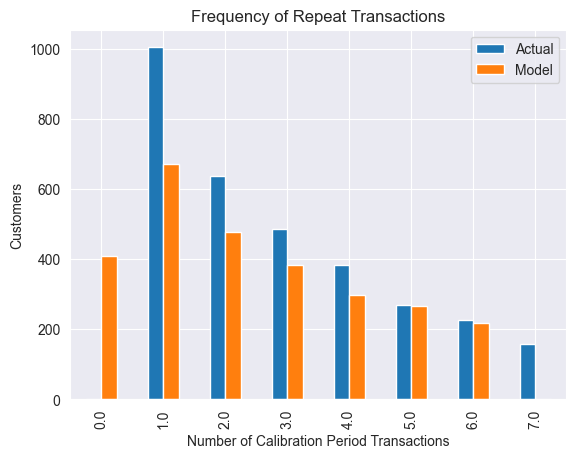

In [5]:
from lifetimes.plotting import plot_period_transactions

# Plot the expected number of transactions in future periods
plot_period_transactions(bgf);

In [6]:
print("Merged max :",  df["InvoiceDate"].max())
print("Merged min :",  df["InvoiceDate"].min())

Merged max : 2011-12-09 12:50:00
Merged min : 2009-12-01 07:45:00


In [14]:
from lifetimes.utils import calibration_and_holdout_data
import pandas as pd

# Define the calibration period end date
calibration_period_end = pd.to_datetime('2011-05-31')

# Create the holdout data
holdout_summary = calibration_and_holdout_data(
    data,
    customer_id_col='CustomerID',
    datetime_col='InvoiceDate',
    monetary_value_col='TotalSales',
    calibration_period_end=calibration_period_end,
    observation_period_end=pd.to_datetime('2011-12-09')
)

# Filter out rows with negative or zero monetary value in the calibration period
holdout_summary = holdout_summary[holdout_summary['monetary_value_cal'] > 0]

# Fit the model on calibration data
bgf.fit(holdout_summary['frequency_cal'], holdout_summary['recency_cal'], holdout_summary['T_cal'])

# Fit the Gamma-Gamma model on calibration data
ggf.fit(holdout_summary['frequency_cal'], holdout_summary['monetary_value_cal'])


<lifetimes.GammaGammaFitter: fitted with 3307 subjects, p: 2.32, q: 3.53, v: 458.67>

Index(['frequency_cal', 'recency_cal', 'T_cal', 'monetary_value_cal',
       'frequency_holdout', 'monetary_value_holdout', 'duration_holdout'],
      dtype='object')
Purchases - MAE: 1.7001853542725647, RMSE: 3.463586456304757, MAPE: 284487200654343.56
CLV - MAE: 155.60833810350903, RMSE: 604.7167607960554, MAPE: 1.0837291449052784e+17
Holdout columns for frequency, recency, and T are not available.


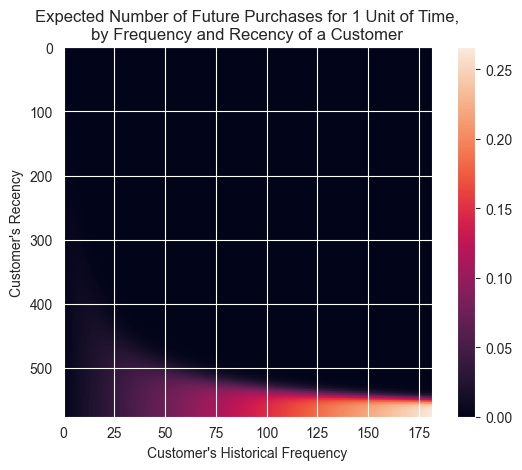

In [20]:
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.plotting import plot_frequency_recency_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, roc_auc_score, mean_absolute_percentage_error
import numpy as np
import matplotlib.pyplot as plt

# Define the calibration and holdout periods
calibration_period_end = '2011-06-30'  # Adjust this date based on your dataset

# Generate calibration and holdout data
holdout_summary = calibration_and_holdout_data(data, 
                                               customer_id_col='CustomerID', 
                                               datetime_col='InvoiceDate', 
                                               monetary_value_col='TotalSales',
                                               calibration_period_end=calibration_period_end,
                                               observation_period_end='2011-12-09')

# Check the columns of holdout_summary to understand the structure
print(holdout_summary.columns)

# Filter out rows with negative or zero monetary value
holdout_summary = holdout_summary[holdout_summary["monetary_value_cal"] > 0]

# Fit the BG/NBD model on the calibration data
bgf.fit(holdout_summary['frequency_cal'], holdout_summary['recency_cal'], holdout_summary['T_cal'])

# Predict purchases in the holdout period
holdout_summary['predicted_purchases_holdout'] = bgf.predict(30, 
                                                             holdout_summary['frequency_cal'], 
                                                             holdout_summary['recency_cal'], 
                                                             holdout_summary['T_cal'])

# Calculate error metrics for purchases
mae_purchases = mean_absolute_error(holdout_summary['frequency_holdout'], holdout_summary['predicted_purchases_holdout'])
rmse_purchases = np.sqrt(mean_squared_error(holdout_summary['frequency_holdout'], holdout_summary['predicted_purchases_holdout']))
mape_purchases = mean_absolute_percentage_error(holdout_summary['frequency_holdout'], holdout_summary['predicted_purchases_holdout'])
print(f"Purchases - MAE: {mae_purchases}, RMSE: {rmse_purchases}, MAPE: {mape_purchases}")

# Fit the Gamma-Gamma model on the calibration data
ggf.fit(holdout_summary['frequency_cal'], holdout_summary['monetary_value_cal'])

# Predict CLV in the holdout period
holdout_summary['predicted_clv'] = ggf.customer_lifetime_value(bgf, 
                                                               holdout_summary['frequency_cal'],
                                                               holdout_summary['recency_cal'],
                                                               holdout_summary['T_cal'],
                                                               holdout_summary['monetary_value_cal'],
                                                               time=1, 
                                                               freq='D', 
                                                               discount_rate=0.01)

# Calculate error metrics for CLV
actual_revenue = holdout_summary['monetary_value_holdout']
predicted_clv = holdout_summary['predicted_clv']
mae_clv = mean_absolute_error(actual_revenue, predicted_clv)
rmse_clv = np.sqrt(mean_squared_error(actual_revenue, predicted_clv))
mape_clv = mean_absolute_percentage_error(actual_revenue, predicted_clv)
print(f"CLV - MAE: {mae_clv}, RMSE: {rmse_clv}, MAPE: {mape_clv}")

# Calculate the probability that customers are still alive in the holdout period
# Ensure that columns exist for frequency_holdout, recency_holdout, and T_holdout
if 'frequency_holdout' in holdout_summary.columns and 'recency_holdout' in holdout_summary.columns and 'T_holdout' in holdout_summary.columns:
    holdout_summary['probability_alive_holdout'] = bgf.conditional_probability_alive(
        holdout_summary['frequency_holdout'], 
        holdout_summary['recency_holdout'], 
        holdout_summary['T_holdout']
    )

    # Create a binary column 'is_alive' based on whether the customer made a purchase in the holdout period
    holdout_summary['is_alive'] = holdout_summary['frequency_holdout'] > 0

    # Calculate ROC AUC for probability of being alive
    roc_auc = roc_auc_score(holdout_summary['is_alive'], holdout_summary['probability_alive_holdout'])
    print(f"ROC AUC for probability of being alive: {roc_auc}")
else:
    print("Holdout columns for frequency, recency, and T are not available.")

# Plot the frequency-recency matrix
plot_frequency_recency_matrix(bgf)
plt.show()


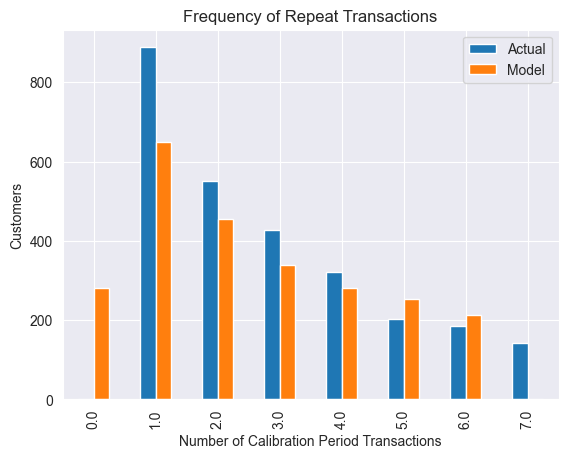

In [23]:
plot_period_transactions(bgf);


In [6]:
from lifetimes.utils import calibration_and_holdout_data
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Split the data into calibration and holdout periods
calibration_holdout = calibration_and_holdout_data(data, 
                                                   customer_id_col='CustomerID', 
                                                   datetime_col='InvoiceDate', 
                                                   monetary_value_col='TotalSales',
                                                   calibration_period_end='YYYY-MM-DD', # Replace with your date
                                                   observation_period_end=max(df["InvoiceDate"]))

calibration_summary = calibration_holdout[calibration_holdout['monetary_value_cal'] > 0]
holdout_summary = calibration_holdout[calibration_holdout['monetary_value_holdout'] > 0]

# Fit the BG/NBD model on the calibration period
bgf_calibration = BetaGeoFitter(penalizer_coef=0.0)
bgf_calibration.fit(calibration_summary['frequency_cal'], calibration_summary['recency_cal'], calibration_summary['T_cal'])

# Fit the Gamma-Gamma model on the calibration period
ggf_calibration = GammaGammaFitter(penalizer_coef=0.0)
ggf_calibration.fit(calibration_summary['frequency_cal'], calibration_summary['monetary_value_cal'])

# Predict the number of purchases for the holdout period
holdout_summary['predicted_purchases'] = bgf_calibration.predict(holdout_summary['duration_holdout'], 
                                                                 holdout_summary['frequency_cal'], 
                                                                 holdout_summary['recency_cal'], 
                                                                 holdout_summary['T_cal'])

# Predict the customer lifetime value for the holdout period
holdout_summary['predicted_clv'] = ggf_calibration.customer_lifetime_value(bgf_calibration, 
                                                                           holdout_summary['frequency_cal'], 
                                                                           holdout_summary['recency_cal'], 
                                                                           holdout_summary['T_cal'], 
                                                                           holdout_summary['monetary_value_cal'], 
                                                                           time=1, # the lifetime expected for the user in months
                                                                           freq='D', 
                                                                           discount_rate=0.01)

# Calculate MAE and RMSE for the number of purchases
mae_purchases = mean_absolute_error(holdout_summary['frequency_holdout'], holdout_summary['predicted_purchases'])
rmse_purchases = np.sqrt(mean_squared_error(holdout_summary['frequency_holdout'], holdout_summary['predicted_purchases']))

# Calculate MAE and RMSE for the customer lifetime value
mae_clv = mean_absolute_error(holdout_summary['monetary_value_holdout'], holdout_summary['predicted_clv'])
rmse_clv = np.sqrt(mean_squared_error(holdout_summary['monetary_value_holdout'], holdout_summary['predicted_clv']))

print(f'MAE for purchases: {mae_purchases}')
print(f'RMSE for purchases: {rmse_purchases}')
print(f'MAE for CLV: {mae_clv}')
print(f'RMSE for CLV: {rmse_clv}')


DateParseError: Unknown datetime string format, unable to parse: YYYY-MM-DD, at position 0

MAE for purchases: 1.0
RMSE for purchases: 1.0
MAE for CLV: 6130.616290166272
RMSE for CLV: 29120.740313266277


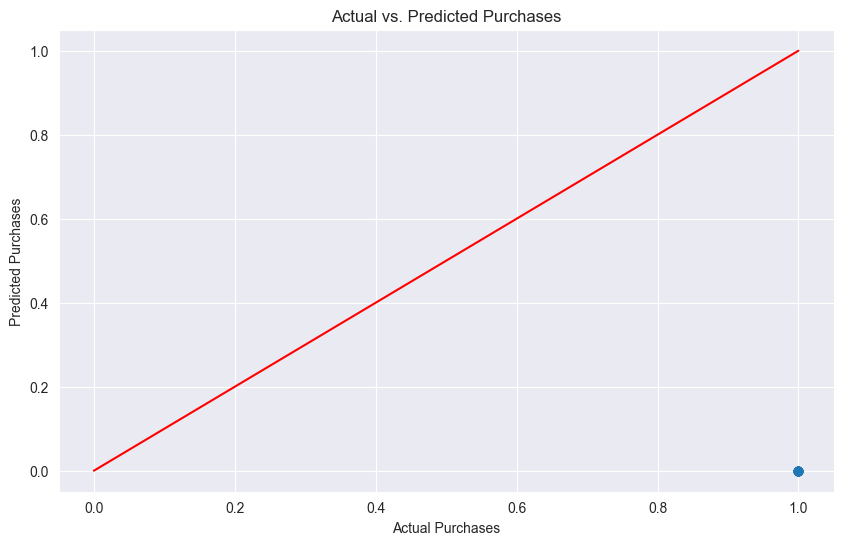

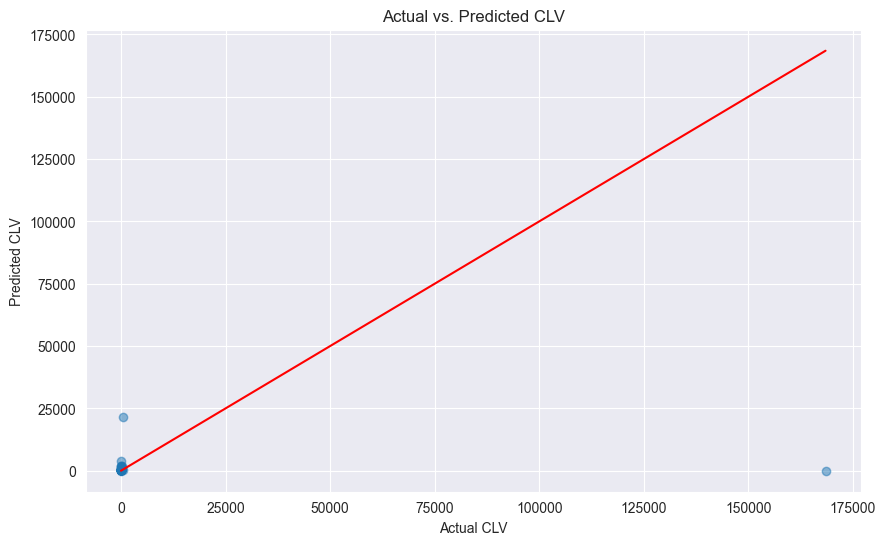

In [8]:
import pandas as pd
import numpy as np
from lifetimes import GammaGammaFitter, BetaGeoFitter
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.utils import summary_data_from_transaction_data, calibration_and_holdout_data
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Assuming `data` is your transaction data
# Ensure 'InvoiceDate' column is datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Create summary data from transaction data
summary = summary_data_from_transaction_data(data, 
                                             customer_id_col='CustomerID', 
                                             datetime_col='InvoiceDate', 
                                             monetary_value_col='TotalSales',
                                             observation_period_end=max(data["InvoiceDate"]))

summary = summary[summary["monetary_value"] > 0]

# Split the data into calibration and holdout periods
calibration_period_end = '2011-12-09'  # Replace with your actual date
observation_period_end = max(data["InvoiceDate"])

calibration_holdout = calibration_and_holdout_data(data, 
                                                   customer_id_col='CustomerID', 
                                                   datetime_col='InvoiceDate', 
                                                   monetary_value_col='TotalSales',
                                                   calibration_period_end=calibration_period_end, 
                                                   observation_period_end=observation_period_end)

calibration_summary = calibration_holdout[calibration_holdout['monetary_value_cal'] > 0]
holdout_summary = calibration_holdout[calibration_holdout['monetary_value_holdout'] > 0]

# Fit the BG/NBD model on the calibration period
bgf_calibration = BetaGeoFitter(penalizer_coef=0.0)
bgf_calibration.fit(calibration_summary['frequency_cal'], calibration_summary['recency_cal'], calibration_summary['T_cal'])

# Fit the Gamma-Gamma model on the calibration period
ggf_calibration = GammaGammaFitter(penalizer_coef=0.0)
ggf_calibration.fit(calibration_summary['frequency_cal'], calibration_summary['monetary_value_cal'])

# Predict the number of purchases for the holdout period
holdout_summary['predicted_purchases'] = bgf_calibration.predict(holdout_summary['duration_holdout'], 
                                                                 holdout_summary['frequency_cal'], 
                                                                 holdout_summary['recency_cal'], 
                                                                 holdout_summary['T_cal'])

# Predict the customer lifetime value for the holdout period
holdout_summary['predicted_clv'] = ggf_calibration.customer_lifetime_value(bgf_calibration, 
                                                                           holdout_summary['frequency_cal'], 
                                                                           holdout_summary['recency_cal'], 
                                                                           holdout_summary['T_cal'], 
                                                                           holdout_summary['monetary_value_cal'], 
                                                                           time=1,  # The lifetime expected for the user in months
                                                                           freq='D', 
                                                                           discount_rate=0.01)

# Calculate MAE and RMSE for the number of purchases
mae_purchases = mean_absolute_error(holdout_summary['frequency_holdout'], holdout_summary['predicted_purchases'])
rmse_purchases = np.sqrt(mean_squared_error(holdout_summary['frequency_holdout'], holdout_summary['predicted_purchases']))

# Calculate MAE and RMSE for the customer lifetime value
mae_clv = mean_absolute_error(holdout_summary['monetary_value_holdout'], holdout_summary['predicted_clv'])
rmse_clv = np.sqrt(mean_squared_error(holdout_summary['monetary_value_holdout'], holdout_summary['predicted_clv']))

print(f'MAE for purchases: {mae_purchases}')
print(f'RMSE for purchases: {rmse_purchases}')
print(f'MAE for CLV: {mae_clv}')
print(f'RMSE for CLV: {rmse_clv}')

# Visual Inspection

# Plot predicted vs. actual purchases
plt.figure(figsize=(10, 6))
plt.scatter(holdout_summary['frequency_holdout'], holdout_summary['predicted_purchases'], alpha=0.5)
plt.xlabel('Actual Purchases')
plt.ylabel('Predicted Purchases')
plt.title('Actual vs. Predicted Purchases')
plt.plot([0, max(holdout_summary['frequency_holdout'])], [0, max(holdout_summary['frequency_holdout'])], color='red')
plt.show()

# Plot predicted vs. actual CLV
plt.figure(figsize=(10, 6))
plt.scatter(holdout_summary['monetary_value_holdout'], holdout_summary['predicted_clv'], alpha=0.5)
plt.xlabel('Actual CLV')
plt.ylabel('Predicted CLV')
plt.title('Actual vs. Predicted CLV')
plt.plot([0, max(holdout_summary['monetary_value_holdout'])], [0, max(holdout_summary['monetary_value_holdout'])], color='red')
plt.show()


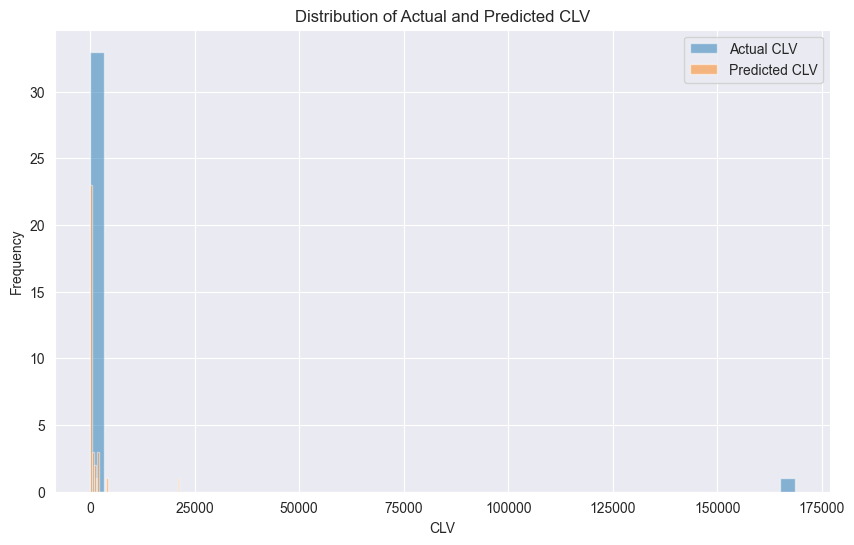

In [9]:
# Plot the distribution of actual and predicted CLV values
plt.figure(figsize=(10, 6))
plt.hist(holdout_summary['monetary_value_holdout'], bins=50, alpha=0.5, label='Actual CLV')
plt.hist(holdout_summary['predicted_clv'], bins=50, alpha=0.5, label='Predicted CLV')
plt.xlabel('CLV')
plt.ylabel('Frequency')
plt.title('Distribution of Actual and Predicted CLV')
plt.legend()
plt.show()


In [10]:
# Define a threshold to remove outliers
threshold = holdout_summary['monetary_value_holdout'].quantile(0.99)

# Filter out outliers
filtered_summary = holdout_summary[holdout_summary['monetary_value_holdout'] < threshold]

# Recalculate MAE and RMSE for the filtered data
mae_clv_filtered = mean_absolute_error(filtered_summary['monetary_value_holdout'], filtered_summary['predicted_clv'])
rmse_clv_filtered = np.sqrt(mean_squared_error(filtered_summary['monetary_value_holdout'], filtered_summary['predicted_clv']))

print(f'Filtered MAE for CLV: {mae_clv_filtered}')
print(f'Filtered RMSE for CLV: {rmse_clv_filtered}')


Filtered MAE for CLV: 1213.0585829606753
Filtered RMSE for CLV: 3776.564534089257


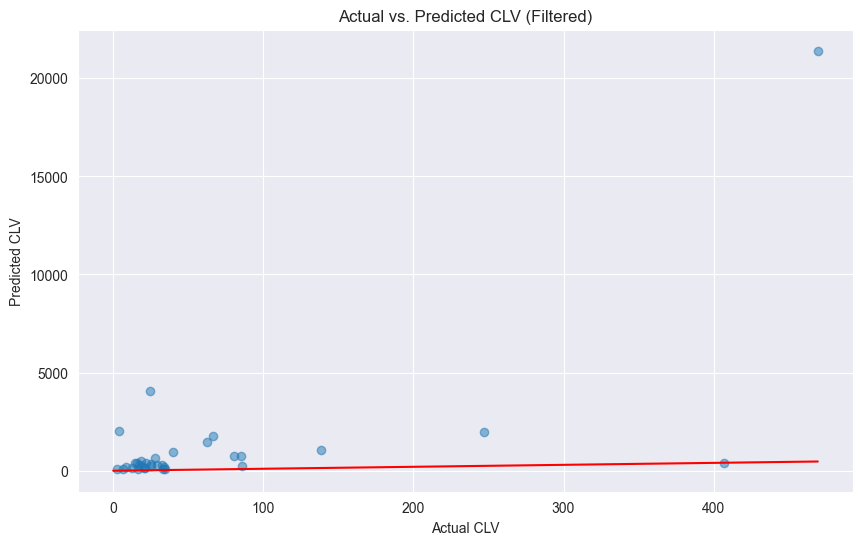

In [11]:
# Plot predicted vs. actual CLV for filtered data
plt.figure(figsize=(10, 6))
plt.scatter(filtered_summary['monetary_value_holdout'], filtered_summary['predicted_clv'], alpha=0.5)
plt.xlabel('Actual CLV')
plt.ylabel('Predicted CLV')
plt.title('Actual vs. Predicted CLV (Filtered)')
plt.plot([0, max(filtered_summary['monetary_value_holdout'])], [0, max(filtered_summary['monetary_value_holdout'])], color='red')
plt.show()


In [12]:
from lifetimes.utils import calibration_and_holdout_data
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score, KFold

# Define a custom scorer for cross-validation
def clv_scorer(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

scorer = make_scorer(clv_scorer, greater_is_better=False)

# Prepare the data
calibration_holdout = calibration_and_holdout_data(data, 
                                                   customer_id_col='CustomerID', 
                                                   datetime_col='InvoiceDate', 
                                                   monetary_value_col='TotalSales',
                                                   calibration_period_end='2011-12-09',  # Replace with your actual date
                                                   observation_period_end=max(data["InvoiceDate"]))

calibration_summary = calibration_holdout[calibration_holdout['monetary_value_cal'] > 0]
holdout_summary = calibration_holdout[calibration_holdout['monetary_value_holdout'] > 0]

# Initialize the models
bgf = BetaGeoFitter(penalizer_coef=0.0)
ggf = GammaGammaFitter(penalizer_coef=0.0)

# Cross-validation for BG/NBD model
cv = KFold(n_splits=5, shuffle=True, random_state=42)
bgf_scores = cross_val_score(bgf, calibration_summary[['frequency_cal', 'recency_cal', 'T_cal']], calibration_summary['monetary_value_cal'], cv=cv, scoring=scorer)

# Cross-validation for Gamma-Gamma model
ggf_scores = cross_val_score(ggf, calibration_summary[['frequency_cal', 'monetary_value_cal']], calibration_summary['monetary_value_cal'], cv=cv, scoring=scorer)

print(f'BG/NBD Cross-Validation Scores: {bgf_scores}')
print(f'Gamma-Gamma Cross-Validation Scores: {ggf_scores}')


TypeError: Cannot clone object '<lifetimes.BetaGeoFitter>' (type <class 'lifetimes.fitters.beta_geo_fitter.BetaGeoFitter'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' method.

In [13]:
# Add more features to your summary data
summary['avg_order_value'] = summary['monetary_value'] / summary['frequency']
summary['days_between_purchases'] = summary['recency'] / summary['frequency']

# Refit the models with the new features
bgf.fit(summary['frequency'], summary['recency'], summary['T'])
ggf.fit(summary['frequency'], summary['monetary_value'])


<lifetimes.GammaGammaFitter: fitted with 4189 subjects, p: 2.13, q: 3.53, v: 486.53>

In [14]:
from sklearn.model_selection import GridSearchCV
from lifetimes import BetaGeoFitter, GammaGammaFitter

# Define the parameter grid for BG/NBD
param_grid_bg = {'penalizer_coef': [0.0, 0.01, 0.1, 1.0]}
bgf = BetaGeoFitter()

# Use GridSearchCV to find the best hyperparameters for BG/NBD
grid_search_bg = GridSearchCV(bgf, param_grid_bg, cv=5, scoring='neg_mean_absolute_error')
grid_search_bg.fit(summary[['frequency', 'recency', 'T']], summary['monetary_value'])

# Define the parameter grid for Gamma-Gamma
param_grid_gg = {'penalizer_coef': [0.0, 0.01, 0.1, 1.0]}
ggf = GammaGammaFitter()

# Use GridSearchCV to find the best hyperparameters for Gamma-Gamma
grid_search_gg = GridSearchCV(ggf, param_grid_gg, cv=5, scoring='neg_mean_absolute_error')
grid_search_gg.fit(summary[['frequency', 'monetary_value']], summary['monetary_value'])

# Get the best models
best_bgf = grid_search_bg.best_estimator_
best_ggf = grid_search_gg.best_estimator_

# Print the best parameters
print(f"Best parameters for BG/NBD: {grid_search_bg.best_params_}")
print(f"Best parameters for Gamma-Gamma: {grid_search_gg.best_params_}")


TypeError: Cannot clone object '<lifetimes.BetaGeoFitter>' (type <class 'lifetimes.fitters.beta_geo_fitter.BetaGeoFitter'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' method.

Best penalizer for BG/NBD: 0.0 with MAE: 1.0
Best penalizer for Gamma-Gamma: 0.0 with MAE: 6130.616290166272


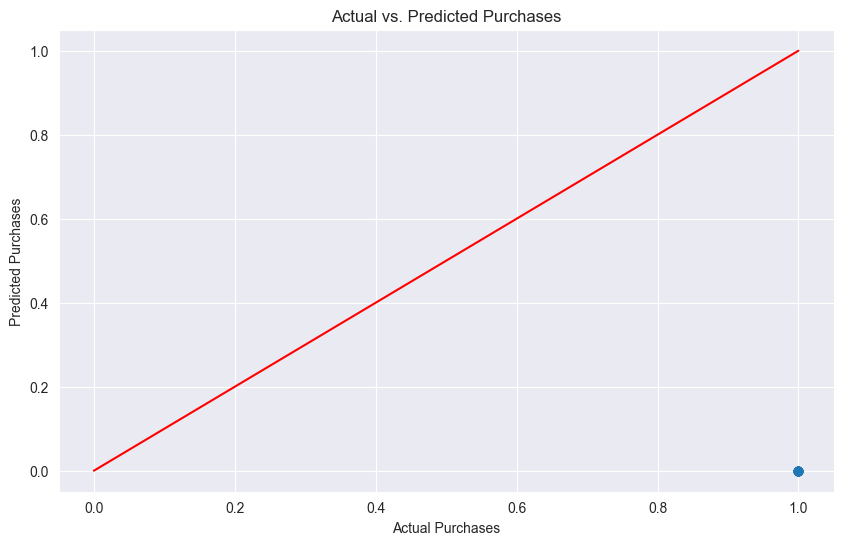

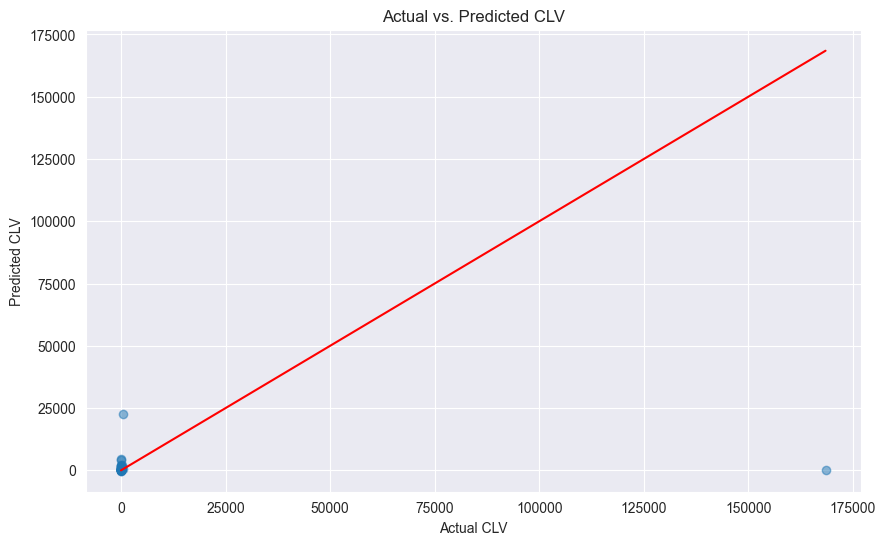

In [15]:
import pandas as pd
import numpy as np
from lifetimes import BetaGeoFitter, GammaGammaFitter
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Add more features to your summary data
summary = summary_data_from_transaction_data(data, 
                                             customer_id_col='CustomerID', 
                                             datetime_col='InvoiceDate', 
                                             monetary_value_col='TotalSales',
                                             observation_period_end=max(data["InvoiceDate"]))

summary['avg_order_value'] = summary['monetary_value'] / summary['frequency']
summary['days_between_purchases'] = summary['recency'] / summary['frequency']

# Define parameter grid for BG/NBD and Gamma-Gamma models
param_grid_bg = [0.0, 0.01, 0.1, 1.0]
param_grid_gg = [0.0, 0.01, 0.1, 1.0]

# Initialize variables to store best parameters and scores
best_bgf = None
best_ggf = None
best_bgf_score = float('inf')
best_ggf_score = float('inf')
best_bgf_params = None
best_ggf_params = None

# Split the data into calibration and holdout periods
calibration_holdout = calibration_and_holdout_data(data, 
                                                   customer_id_col='CustomerID', 
                                                   datetime_col='InvoiceDate', 
                                                   monetary_value_col='TotalSales',
                                                   calibration_period_end='2011-12-09',  # Replace with your actual date
                                                   observation_period_end=max(data["InvoiceDate"]))

calibration_summary = calibration_holdout[calibration_holdout['monetary_value_cal'] > 0]
holdout_summary = calibration_holdout[calibration_holdout['monetary_value_holdout'] > 0]

# Manual search for best penalizer coefficient for BG/NBD
for penalizer in param_grid_bg:
    bgf = BetaGeoFitter(penalizer_coef=penalizer)
    bgf.fit(calibration_summary['frequency_cal'], calibration_summary['recency_cal'], calibration_summary['T_cal'])
    holdout_summary['predicted_purchases'] = bgf.predict(holdout_summary['duration_holdout'], 
                                                         holdout_summary['frequency_cal'], 
                                                         holdout_summary['recency_cal'], 
                                                         holdout_summary['T_cal'])
    mae = mean_absolute_error(holdout_summary['frequency_holdout'], holdout_summary['predicted_purchases'])
    if mae < best_bgf_score:
        best_bgf_score = mae
        best_bgf = bgf
        best_bgf_params = penalizer

# Manual search for best penalizer coefficient for Gamma-Gamma
for penalizer in param_grid_gg:
    ggf = GammaGammaFitter(penalizer_coef=penalizer)
    ggf.fit(calibration_summary['frequency_cal'], calibration_summary['monetary_value_cal'])
    holdout_summary['predicted_clv'] = ggf.customer_lifetime_value(best_bgf, 
                                                                   holdout_summary['frequency_cal'], 
                                                                   holdout_summary['recency_cal'], 
                                                                   holdout_summary['T_cal'], 
                                                                   holdout_summary['monetary_value_cal'], 
                                                                   time=1, 
                                                                   freq='D', 
                                                                   discount_rate=0.01)
    mae = mean_absolute_error(holdout_summary['monetary_value_holdout'], holdout_summary['predicted_clv'])
    if mae < best_ggf_score:
        best_ggf_score = mae
        best_ggf = ggf
        best_ggf_params = penalizer

# Print the best parameters and scores
print(f"Best penalizer for BG/NBD: {best_bgf_params} with MAE: {best_bgf_score}")
print(f"Best penalizer for Gamma-Gamma: {best_ggf_params} with MAE: {best_ggf_score}")

# Visual Inspection

# Plot predicted vs. actual purchases
plt.figure(figsize=(10, 6))
plt.scatter(holdout_summary['frequency_holdout'], holdout_summary['predicted_purchases'], alpha=0.5)
plt.xlabel('Actual Purchases')
plt.ylabel('Predicted Purchases')
plt.title('Actual vs. Predicted Purchases')
plt.plot([0, max(holdout_summary['frequency_holdout'])], [0, max(holdout_summary['frequency_holdout'])], color='red')
plt.show()

# Plot predicted vs. actual CLV
plt.figure(figsize=(10, 6))
plt.scatter(holdout_summary['monetary_value_holdout'], holdout_summary['predicted_clv'], alpha=0.5)
plt.xlabel('Actual CLV')
plt.ylabel('Predicted CLV')
plt.title('Actual vs. Predicted CLV')
plt.plot([0, max(holdout_summary['monetary_value_holdout'])], [0, max(holdout_summary['monetary_value_holdout'])], color='red')
plt.show()
